      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
0               7.4             0.700         0.00             1.9      0.076  \
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  

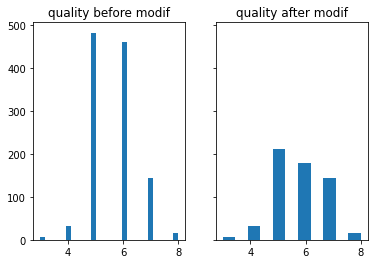

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('WineQT.csv')
print(df)
import numpy as np
import matplotlib.pyplot as plt
# load the dataset

y_train = df['quality']
X_train= [df['volatile acidity'],df['alcohol'],df['sulphates'],df['citric acid']]
X_features = ['volatile acidity','alcohol','sulphates','citric acid']
X_train=np.transpose(np.asmatrix(X_train))
y_train=np.asarray(y_train)


def zscore_normalize_features(X):
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(X_norm)
import random
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(df["quality"], bins='auto',label="quality")
ax[0].set_title("quality before modif")
supp=[]
#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 3)
for i in range(len(y_train)):
    if y_train[i]==5 or y_train[i]==6:
        rand=random.random()
        if(rand>0.4):
            supp.append(i)
for j in range(len(supp)):
    y_train2=np.delete(y_train,supp)
    X_norm2=np.delete(X_norm,supp,0)


ax[1].hist(y_train2, bins='auto',label="quality")
ax[1].set_title("quality after modif")

print(y_train2.shape)
print(X_norm2.shape)

DIVISION DU JEU DE DONNEES EN TRAIN SET, CROSS VALIDATION ET TEST SET:

In [18]:
print(X_norm2.shape)
print(y_train2.shape)

debutcv=int(X_norm2.shape[0]*0.6)
debuttest=int(X_norm2.shape[0]*0.8)

X_train=X_norm2[0:debutcv]
X_cv=X_norm2[debutcv:debuttest]
X_test=X_norm2[debuttest:]

y_train=y_train2[0:debutcv]
y_cv=y_train2[debutcv:debuttest]
y_test=y_train2[debuttest:]

print(X_train.shape,X_cv.shape,X_test.shape)
print(y_train.shape,y_cv.shape,y_test.shape)

(590, 4)
(590,)
(354, 4) (118, 4) (118, 4)
(354,) (118,) (118,)


Creation de 3 modèles à comparer:

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from IPython.display import display, Markdown, Latex
from matplotlib.widgets import Slider
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [43]:
def build_models():
    tf.random.set_seed(20)
    model_1 = Sequential(
        [
            tf.keras.Input(shape=(4,)),
            Dense(25, activation = 'relu'),
            Dense(15, activation = 'relu'),
            Dense(9, activation = 'softmax')
        ],
        name='model_1'
    )
    model_2 = Sequential(
        [
            tf.keras.Input(shape=(4,)),
            Dense(20, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(20, activation = 'relu'),
            Dense(9, activation = 'softmax')
        ],
        name='model_2'
    )
    model_3 = Sequential(
        [
            tf.keras.Input(shape=(4,)),
            Dense(32, activation = 'relu'),
            Dense(16, activation = 'relu'),
            Dense(8, activation = 'relu'),
            Dense(4, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(9, activation = 'softmax')
        ],
        name='model_3'
    )
    
    model_list = [model_1, model_2, model_3]

    return model_list

In [46]:
def locateMax(tab):
    max=0
    for loop in range(len(tab)):
        if tab[loop]>tab[max]:
            max=loop
    return max

In [49]:
def accuracy(y,yp):
    m=len(y)
    sum=0
    for loop in range(m):
        if(yp[loop] == y[loop]):
            sum+=1
    return((sum/m)*100)

In [50]:

from sklearn.metrics import mean_squared_error
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []


# Build the models
nn_models = build_models()

# Loop over the the models
for model in nn_models:
    
    # Setup the loss and optimizer
    model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    print(f"Training {model.name}...")
    
    
    # Train the model
    model.fit(
        X_train, y_train,
        epochs=200,
        verbose=0
    )
    
    print("Done!\n")

    # Set the threshold for classification
    threshold = 0.5
    # Record the fraction of misclassified examples for the training set
    predictions = model.predict(X_train)
    yhat= np.zeros(len(predictions))

    for loop in range(len(predictions)):
        yhat[loop]=locateMax(predictions[loop])
    print(yhat)

    train_error = accuracy(yhat,y_train)
    nn_train_error.append(train_error)

    # Record the fraction of misclassified examples for the cross validation set
    predictions = model.predict(X_cv)
    yhat= np.zeros(len(predictions))

    for loop in range(len(predictions)):
        yhat[loop]=locateMax(predictions[loop])
    print(yhat)

    cv_error = accuracy(yhat,y_cv)
    nn_cv_error.append(cv_error)

    
# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )

Training model_1...
Done!

12/12 [==============================] - 0s 3ms/step
[5. 5. 5. 5. 6. 5. 7. 5. 5. 5. 5. 5. 5. 5. 7. 5. 5. 4. 5. 6. 5. 5. 5. 6.
 5. 7. 5. 4. 5. 6. 5. 5. 5. 5. 5. 4. 5. 6. 6. 5. 5. 5. 6. 5. 6. 6. 6. 5.
 5. 6. 5. 5. 4. 5. 6. 5. 5. 6. 4. 6. 5. 5. 5. 5. 6. 6. 5. 5. 5. 5. 5. 5.
 6. 6. 4. 6. 7. 7. 5. 5. 5. 5. 5. 6. 6. 5. 5. 7. 7. 7. 6. 6. 6. 5. 5. 5.
 7. 4. 4. 8. 7. 8. 6. 7. 6. 5. 5. 7. 5. 7. 6. 6. 6. 6. 5. 5. 5. 5. 6. 6.
 7. 5. 7. 7. 6. 6. 5. 7. 7. 5. 5. 7. 7. 5. 7. 6. 6. 7. 6. 6. 8. 5. 7. 5.
 6. 5. 5. 6. 5. 6. 7. 5. 7. 5. 5. 5. 7. 5. 7. 7. 7. 6. 8. 7. 7. 6. 6. 7.
 5. 8. 5. 3. 6. 6. 6. 5. 5. 8. 5. 6. 7. 7. 6. 8. 6. 8. 7. 7. 6. 7. 6. 7.
 6. 6. 7. 7. 3. 5. 7. 5. 6. 6. 6. 5. 6. 7. 5. 6. 6. 5. 6. 6. 5. 5. 6. 6.
 6. 5. 6. 5. 6. 8. 5. 5. 5. 6. 6. 5. 6. 5. 5. 5. 5. 5. 4. 5. 5. 6. 5. 4.
 7. 5. 6. 5. 6. 5. 5. 5. 5. 5. 6. 5. 5. 5. 5. 5. 6. 5. 5. 4. 5. 5. 6. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 6. 6. 5. 5. 5. 5. 5. 5. 6. 6. 6. 5. 6. 6. 6. 5.
 5. 7. 7. 5. 7. 7. 5. 7. 5. 4. 5. 5. 7. 7. 5

UnboundLocalError: local variable 'sum' referenced before assignment

In [34]:
# Select the model with the lowest CV MSE
model_num = 3

# Compute the test MSE
predict = model.predict(X_cv)
yhat=tf.nn.softmax(predict).numpy()
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Selected Model: {model_num}")
print(f"Training MSE: {nn_train_mses[model_num-1]:.2f}")
print(f"Cross Validation MSE: {nn_cv_mses[model_num-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

4/4 [==============================] - 0s 4ms/step
Selected Model: 3
Training MSE: 11.74
Cross Validation MSE: 13.65
Test MSE: 11.08


VISUALISATION TEST DU MODELE CHOISI 

In [35]:
print(yhat)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [ ]:


x_plot=np.array(X_test)
y_plot=np.array(y_test).reshape(-1,1)
print(X_test.shape, y_test.shape)


m = X_test.shape[0]

predictions = nn_models[model_num-1].predict(X_test)
for loop in range(len(predictions)):
    yp_all[loop]=locateMax(predictions[loop])

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter([x_all[:,i]],y_all, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter([x_all[:,i]],yp_all,color="orange", label = 'predict')
ax[0].set_ylabel("Quality"); ax[0].legend()
fig.suptitle("target versus prediction using Softmax model")
plt.show()